# Part 3: RNN Scaling Study and Comparison

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import json
import math
import time
from pathlib import Path
from google.colab import drive

In [ ]:
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
data_dir = Path('/content/drive/MyDrive/MLProject/data')
output_dir = Path('/content/drive/MyDrive/MLProject/results')
output_dir.mkdir(parents=True, exist_ok=True)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")
if torch.cuda.is_available():
    print(f"GPU: {torch.cuda.get_device_name(0)}")
    print(f"Memory: {torch.cuda.get_device_properties(0).total_memory / 1e9:.1f} GB")

Using device: cuda
GPU: NVIDIA A100-SXM4-80GB
Memory: 85.2 GB


## Load Data

In [ ]:
train_data = np.load(data_dir / 'train.npy')
val_data = np.load(data_dir / 'val.npy')

with open(data_dir / 'tokenizer.json', 'r') as f:
    token2idx = json.load(f)

vocab_size = len(token2idx)
print(f"Vocab size: {vocab_size}")
print(f"Train tokens: {len(train_data):,}")
print(f"Val tokens: {len(val_data):,}")

Vocab size: 27224
Train tokens: 1,167,894,118
Val tokens: 11,907,471


## Load Fixed Indices

In [ ]:
train_indices = np.load(data_dir / 'train_indices.npy')
val_indices = np.load(data_dir / 'val_indices.npy')

print(f"Train indices: {len(train_indices):,}")
print(f"Val indices: {len(val_indices):,}")

Train indices: 390,625
Val indices: 39,062


## Dataset

In [ ]:
class MusicDataset(Dataset):
    def __init__(self, data, context_length, indices):
        self.data = torch.from_numpy(data.astype(np.int64))
        self.context_length = context_length
        self.indices = indices

    def __len__(self):
        return len(self.indices)

    def __getitem__(self, idx):
        start = self.indices[idx]
        x = self.data[start:start + self.context_length]
        y = self.data[start + 1:start + self.context_length + 1]
        return x, y

## LSTM Model

In [ ]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, hidden_size, num_layers, dropout=0.1):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        self.embedding = nn.Embedding(vocab_size, hidden_size)
        self.lstm = nn.LSTM(hidden_size, hidden_size, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.fc = nn.Linear(hidden_size, vocab_size)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x, hidden=None):
        x = self.dropout(self.embedding(x))
        out, hidden = self.lstm(x, hidden)
        out = self.fc(out)
        return out, hidden

    def count_parameters(self):
        return sum(p.numel() for p in self.parameters() if p.requires_grad)

## Training Configuration

In [ ]:
CONTEXT_LENGTH = 256
BATCH_TOKENS = 4096
BATCH_SIZE = BATCH_TOKENS // CONTEXT_LENGTH
LEARNING_RATE = 3e-4
WARMUP_RATIO = 0.05

LSTM_CONFIGS = {
    'tiny': {'hidden_size': 64, 'num_layers': 1},
    'small': {'hidden_size': 128, 'num_layers': 2},
    'medium': {'hidden_size': 320, 'num_layers': 3},
    'large': {'hidden_size': 680, 'num_layers': 4}
}

print(f"Context length: {CONTEXT_LENGTH}")
print(f"Batch size: {BATCH_SIZE} sequences ({BATCH_TOKENS} tokens)")
print(f"Samples per epoch: {len(train_indices):,}")
print(f"Steps per epoch: {len(train_indices) // BATCH_SIZE:,}")

Context length: 256
Batch size: 16 sequences (4096 tokens)
Samples per epoch: 390,625
Steps per epoch: 24,414


## Training Function

In [ ]:
def get_lr(step, total_steps, warmup_steps, max_lr):
    if step < warmup_steps:
        return max_lr * step / warmup_steps
    else:
        progress = (step - warmup_steps) / (total_steps - warmup_steps)
        return max_lr * 0.5 * (1 + math.cos(math.pi * progress))

In [ ]:
def train_lstm(model_name, config, train_data, val_data, train_indices, val_indices, vocab_size):
    print(f"\n{'='*60}")
    print(f"Training LSTM {model_name.upper()} model")
    print(f"{'='*60}")

    model = LSTMModel(
        vocab_size=vocab_size,
        hidden_size=config['hidden_size'],
        num_layers=config['num_layers']
    ).to(device)

    n_params = model.count_parameters()
    print(f"Parameters: {n_params:,}")
    print(f"Hidden size: {config['hidden_size']}, Layers: {config['num_layers']}")

    train_dataset = MusicDataset(train_data, CONTEXT_LENGTH, train_indices)
    val_dataset = MusicDataset(val_data, CONTEXT_LENGTH, val_indices)

    train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2, pin_memory=True)
    val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2, pin_memory=True)

    optimizer = torch.optim.AdamW(model.parameters(), lr=LEARNING_RATE, weight_decay=0.1)

    total_steps = len(train_loader)
    warmup_steps = int(total_steps * WARMUP_RATIO)

    print(f"Total steps: {total_steps:,}")
    print(f"Warmup steps: {warmup_steps:,}")

    train_losses = []

    gpu_memory = 0
    if torch.cuda.is_available():
        torch.cuda.reset_peak_memory_stats()

    start_time = time.time()

    model.train()
    for step, (x, y) in enumerate(train_loader):
        x, y = x.to(device), y.to(device)

        lr = get_lr(step, total_steps, warmup_steps, LEARNING_RATE)
        for param_group in optimizer.param_groups:
            param_group['lr'] = lr

        logits, _ = model(x)
        loss = F.cross_entropy(logits.view(-1, vocab_size), y.view(-1))

        optimizer.zero_grad()
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        optimizer.step()

        train_losses.append(loss.item())

        if step % 500 == 0:
            elapsed = time.time() - start_time
            remaining = (elapsed / (step + 1)) * (total_steps - step - 1)
            print(f"Step {step}/{total_steps} | Loss: {loss.item():.4f} | LR: {lr:.6f} | Time: {elapsed/60:.1f}m | ETA: {remaining/60:.1f}m")

    train_time = time.time() - start_time

    if torch.cuda.is_available():
        gpu_memory = torch.cuda.max_memory_allocated() / 1e9

    model.eval()
    val_loss_total = 0
    val_steps = 0

    with torch.no_grad():
        for x, y in val_loader:
            x, y = x.to(device), y.to(device)
            logits, _ = model(x)
            loss = F.cross_entropy(logits.view(-1, vocab_size), y.view(-1))
            val_loss_total += loss.item()
            val_steps += 1

    final_val_loss = val_loss_total / val_steps
    final_train_loss = sum(train_losses[-100:]) / min(100, len(train_losses))

    print(f"\nFinal train loss: {final_train_loss:.4f}")
    print(f"Final val loss: {final_val_loss:.4f}")
    print(f"Training time: {train_time/60:.1f} minutes")
    print(f"GPU memory: {gpu_memory:.2f} GB")

    results = {
        'model_name': model_name,
        'n_params': n_params,
        'config': config,
        'final_train_loss': final_train_loss,
        'final_val_loss': final_val_loss,
        'train_losses': train_losses,
        'train_time_seconds': train_time,
        'gpu_memory_gb': gpu_memory
    }

    torch.save(model.state_dict(), output_dir / f'lstm_{model_name}_model.pt')

    del model
    torch.cuda.empty_cache()

    return results

## Train LSTM Tiny

In [ ]:
results_tiny = train_lstm('tiny', LSTM_CONFIGS['tiny'], train_data, val_data, train_indices, val_indices, vocab_size)

with open(output_dir / 'lstm_results_tiny.json', 'w') as f:
    json.dump(results_tiny, f, indent=2)
print("LSTM Tiny model saved")


Training LSTM TINY model
Parameters: 3,545,176
Hidden size: 64, Layers: 1
Total steps: 24,415
Warmup steps: 1,220
Step 0/24415 | Loss: 10.2241 | LR: 0.000000 | Time: 0.0m | ETA: 441.9m
Step 500/24415 | Loss: 5.0423 | LR: 0.000123 | Time: 0.2m | ETA: 10.9m
Step 1000/24415 | Loss: 3.6363 | LR: 0.000246 | Time: 0.4m | ETA: 10.3m
Step 1500/24415 | Loss: 2.3854 | LR: 0.000300 | Time: 0.7m | ETA: 9.9m
Step 2000/24415 | Loss: 2.7450 | LR: 0.000299 | Time: 0.9m | ETA: 9.6m
Step 2500/24415 | Loss: 1.8915 | LR: 0.000298 | Time: 1.1m | ETA: 9.4m
Step 3000/24415 | Loss: 1.6753 | LR: 0.000296 | Time: 1.3m | ETA: 9.1m
Step 3500/24415 | Loss: 1.6721 | LR: 0.000293 | Time: 1.5m | ETA: 8.9m
Step 4000/24415 | Loss: 1.4667 | LR: 0.000289 | Time: 1.7m | ETA: 8.7m
Step 4500/24415 | Loss: 1.6199 | LR: 0.000285 | Time: 1.9m | ETA: 8.5m
Step 5000/24415 | Loss: 1.4453 | LR: 0.000281 | Time: 2.1m | ETA: 8.3m
Step 5500/24415 | Loss: 1.4155 | LR: 0.000275 | Time: 2.3m | ETA: 8.0m
Step 6000/24415 | Loss: 1.5052 |

## Train LSTM Small

In [ ]:
results_small = train_lstm('small', LSTM_CONFIGS['small'], train_data, val_data, train_indices, val_indices, vocab_size)

with open(output_dir / 'lstm_results_small.json', 'w') as f:
    json.dump(results_small, f, indent=2)
print("LSTM Small model saved")


Training LSTM SMALL model
Parameters: 7,260,760
Hidden size: 128, Layers: 2
Total steps: 24,415
Warmup steps: 1,220
Step 0/24415 | Loss: 10.2111 | LR: 0.000000 | Time: 0.0m | ETA: 67.1m
Step 500/24415 | Loss: 4.0324 | LR: 0.000123 | Time: 0.3m | ETA: 12.6m
Step 1000/24415 | Loss: 3.1401 | LR: 0.000246 | Time: 0.5m | ETA: 12.3m
Step 1500/24415 | Loss: 3.4239 | LR: 0.000300 | Time: 0.8m | ETA: 12.0m
Step 2000/24415 | Loss: 3.1345 | LR: 0.000299 | Time: 1.0m | ETA: 11.7m
Step 2500/24415 | Loss: 1.8513 | LR: 0.000298 | Time: 1.3m | ETA: 11.5m
Step 3000/24415 | Loss: 1.0776 | LR: 0.000296 | Time: 1.6m | ETA: 11.2m
Step 3500/24415 | Loss: 1.3585 | LR: 0.000293 | Time: 1.8m | ETA: 10.9m
Step 4000/24415 | Loss: 1.0703 | LR: 0.000289 | Time: 2.1m | ETA: 10.7m
Step 4500/24415 | Loss: 1.0593 | LR: 0.000285 | Time: 2.4m | ETA: 10.4m
Step 5000/24415 | Loss: 1.2420 | LR: 0.000281 | Time: 2.6m | ETA: 10.2m
Step 5500/24415 | Loss: 0.7074 | LR: 0.000275 | Time: 2.9m | ETA: 9.9m
Step 6000/24415 | Loss:

## Train LSTM Medium

In [ ]:
results_medium = train_lstm('medium', LSTM_CONFIGS['medium'], train_data, val_data, train_indices, val_indices, vocab_size)

with open(output_dir / 'lstm_results_medium.json', 'w') as f:
    json.dump(results_medium, f, indent=2)
print("LSTM Medium model saved")


Training LSTM MEDIUM model
Parameters: 19,915,864
Hidden size: 320, Layers: 3
Total steps: 24,415
Warmup steps: 1,220
Step 0/24415 | Loss: 10.2012 | LR: 0.000000 | Time: 0.0m | ETA: 68.8m
Step 500/24415 | Loss: 3.6604 | LR: 0.000123 | Time: 0.5m | ETA: 26.0m
Step 1000/24415 | Loss: 3.1838 | LR: 0.000246 | Time: 1.1m | ETA: 25.3m
Step 1500/24415 | Loss: 3.3530 | LR: 0.000300 | Time: 1.6m | ETA: 24.8m
Step 2000/24415 | Loss: 3.2997 | LR: 0.000299 | Time: 2.2m | ETA: 24.2m
Step 2500/24415 | Loss: 3.3206 | LR: 0.000298 | Time: 2.7m | ETA: 23.7m
Step 3000/24415 | Loss: 4.0278 | LR: 0.000296 | Time: 3.2m | ETA: 23.1m
Step 3500/24415 | Loss: 1.8562 | LR: 0.000293 | Time: 3.8m | ETA: 22.6m
Step 4000/24415 | Loss: 0.9197 | LR: 0.000289 | Time: 4.3m | ETA: 22.1m
Step 4500/24415 | Loss: 1.2126 | LR: 0.000285 | Time: 4.9m | ETA: 21.6m
Step 5000/24415 | Loss: 1.0821 | LR: 0.000281 | Time: 5.4m | ETA: 21.0m
Step 5500/24415 | Loss: 0.6998 | LR: 0.000275 | Time: 6.0m | ETA: 20.5m
Step 6000/24415 | Lo

## Train LSTM Large

In [ ]:
results_large = train_lstm('large', LSTM_CONFIGS['large'], train_data, val_data, train_indices, val_indices, vocab_size)

with open(output_dir / 'lstm_results_large.json', 'w') as f:
    json.dump(results_large, f, indent=2)
print("LSTM Large model saved")


Training LSTM LARGE model
Parameters: 51,870,424
Hidden size: 680, Layers: 4
Total steps: 24,415
Warmup steps: 1,220
Step 0/24415 | Loss: 10.2036 | LR: 0.000000 | Time: 0.0m | ETA: 85.6m
Step 500/24415 | Loss: 3.4311 | LR: 0.000123 | Time: 1.2m | ETA: 55.8m
Step 1000/24415 | Loss: 3.5643 | LR: 0.000246 | Time: 2.3m | ETA: 54.6m
Step 1500/24415 | Loss: 3.1220 | LR: 0.000300 | Time: 3.5m | ETA: 53.5m
Step 2000/24415 | Loss: 3.3339 | LR: 0.000299 | Time: 4.7m | ETA: 52.3m
Step 2500/24415 | Loss: 3.2936 | LR: 0.000298 | Time: 5.8m | ETA: 51.1m
Step 3000/24415 | Loss: 3.5872 | LR: 0.000296 | Time: 7.0m | ETA: 50.0m
Step 3500/24415 | Loss: 3.4577 | LR: 0.000293 | Time: 8.2m | ETA: 48.8m
Step 4000/24415 | Loss: 1.6357 | LR: 0.000289 | Time: 9.3m | ETA: 47.6m
Step 4500/24415 | Loss: 0.9810 | LR: 0.000285 | Time: 10.5m | ETA: 46.5m
Step 5000/24415 | Loss: 0.6618 | LR: 0.000281 | Time: 11.7m | ETA: 45.3m
Step 5500/24415 | Loss: 1.3974 | LR: 0.000275 | Time: 12.8m | ETA: 44.1m
Step 6000/24415 | 

## LSTM Results Summary

In [ ]:
lstm_results = []
for name in ['tiny', 'small', 'medium', 'large']:
    with open(output_dir / f'lstm_results_{name}.json', 'r') as f:
        lstm_results.append(json.load(f))

print("\n" + "="*80)
print("LSTM SCALING STUDY RESULTS")
print("="*80)
print(f"{'Model':<10} {'Params':>12} {'Train Loss':>12} {'Val Loss':>12} {'Time (min)':>12} {'GPU (GB)':>10}")
print("-"*80)

for r in lstm_results:
    print(f"{r['model_name']:<10} {r['n_params']:>12,} {r['final_train_loss']:>12.4f} {r['final_val_loss']:>12.4f} {r['train_time_seconds']/60:>12.1f} {r['gpu_memory_gb']:>10.2f}")

print("="*80)


LSTM SCALING STUDY RESULTS
Model            Params   Train Loss     Val Loss   Time (min)   GPU (GB)
--------------------------------------------------------------------------------
tiny          3,545,176       1.0250       1.0413         10.3       1.86
small         7,260,760       0.8085       0.7972         12.8       1.92
medium       19,915,864       0.6850       0.6251         26.5       2.18
large        51,870,424       0.5776       0.5656         57.0       2.80


## LSTM Scaling Plot

In [ ]:
import matplotlib.pyplot as plt
from scipy.optimize import curve_fit

lstm_params = [r['n_params'] for r in lstm_results]
lstm_val_losses = [r['final_val_loss'] for r in lstm_results]

def power_law(N, a, alpha, c):
    return a * np.power(N, -alpha) + c

try:
    popt, pcov = curve_fit(power_law, lstm_params, lstm_val_losses, p0=[1, 0.1, 0.5], maxfev=10000)
    a_lstm, alpha_lstm, c_lstm = popt
    print(f"LSTM Power law fit: L = {a_lstm:.4f} * N^(-{alpha_lstm:.4f}) + {c_lstm:.4f}")
    print(f"LSTM Scaling exponent α = {alpha_lstm:.4f}")
except:
    print("Could not fit power law for LSTM")
    a_lstm, alpha_lstm, c_lstm = None, None, None

LSTM Power law fit: L = 312622.6242 * N^(-0.8813) + 0.5138
LSTM Scaling exponent α = 0.8813


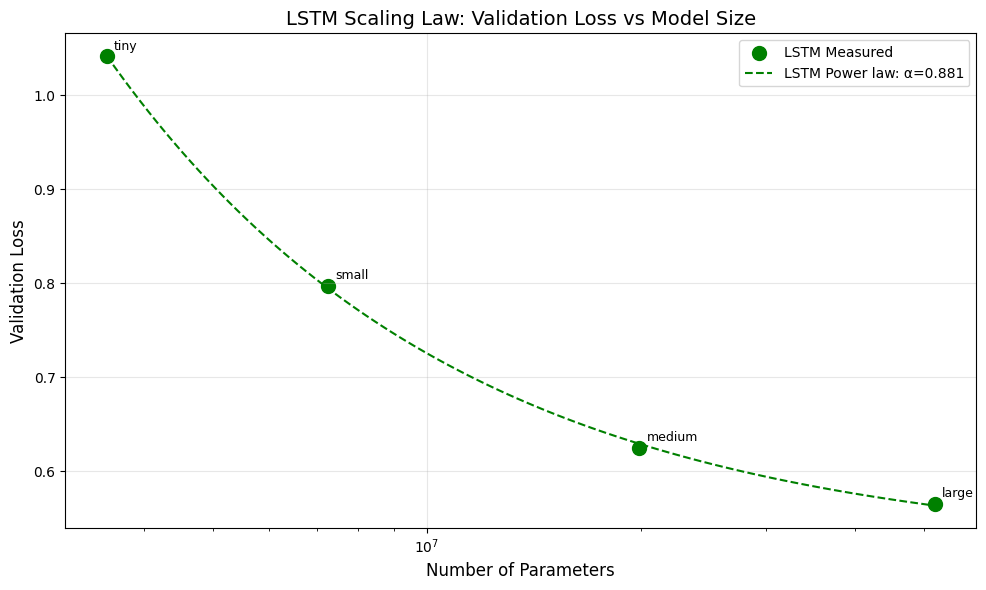

In [ ]:
plt.figure(figsize=(10, 6))

plt.scatter(lstm_params, lstm_val_losses, s=100, c='green', label='LSTM Measured')

for r in lstm_results:
    plt.annotate(r['model_name'], (r['n_params'], r['final_val_loss']),
                 textcoords="offset points", xytext=(5,5), fontsize=9)

if a_lstm is not None:
    x_fit = np.logspace(np.log10(min(lstm_params)), np.log10(max(lstm_params)), 100)
    y_fit = power_law(x_fit, a_lstm, alpha_lstm, c_lstm)
    plt.plot(x_fit, y_fit, 'g--', label=f'LSTM Power law: α={alpha_lstm:.3f}')

plt.xscale('log')
plt.xlabel('Number of Parameters', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)
plt.title('LSTM Scaling Law: Validation Loss vs Model Size', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(output_dir / 'lstm_scaling_plot.png', dpi=150)
plt.show()

## LSTM Training Curves

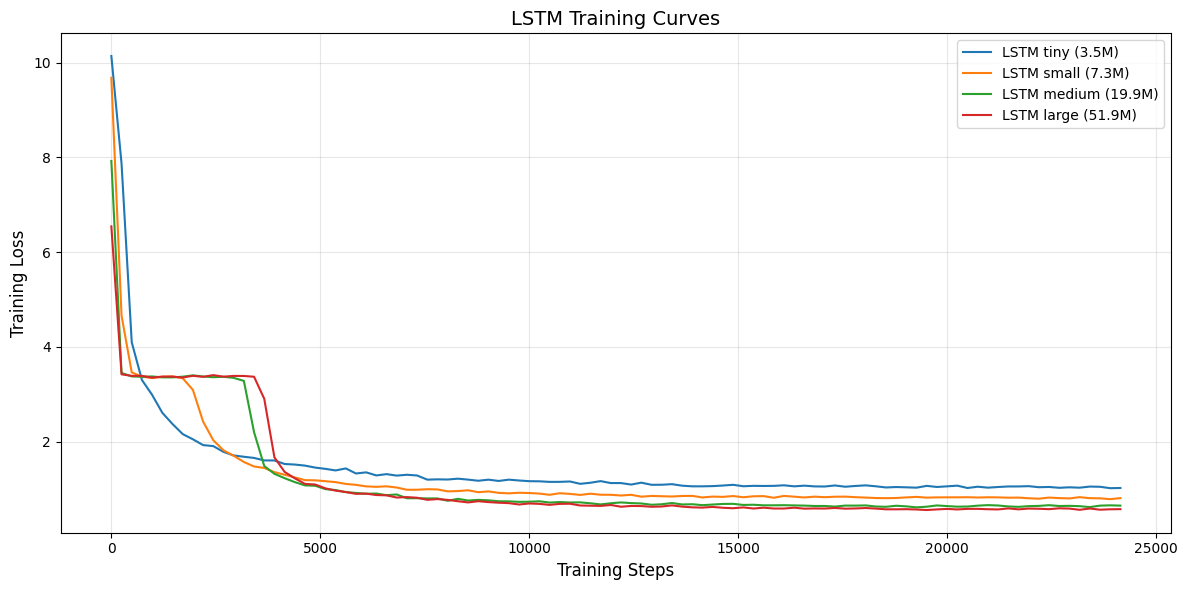

In [ ]:
plt.figure(figsize=(12, 6))

for r in lstm_results:
    losses = r['train_losses']
    window = max(1, len(losses) // 100)
    smoothed = [sum(losses[i:i+window])/window for i in range(0, len(losses)-window, window)]
    steps = [i * window for i in range(len(smoothed))]
    plt.plot(steps, smoothed, label=f"LSTM {r['model_name']} ({r['n_params']/1e6:.1f}M)")

plt.xlabel('Training Steps', fontsize=12)
plt.ylabel('Training Loss', fontsize=12)
plt.title('LSTM Training Curves', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(output_dir / 'lstm_training_curves.png', dpi=150)
plt.show()

## LSTM Architecture Table

In [ ]:
print("\nLSTM Architecture Summary:")
print("="*60)
print(f"{'Model':<10} {'Hidden Size':>12} {'Layers':>10} {'Params':>15}")
print("-"*60)

for r in lstm_results:
    cfg = r['config']
    print(f"{r['model_name']:<10} {cfg['hidden_size']:>12} {cfg['num_layers']:>10} {r['n_params']:>15,}")

print("="*60)


LSTM Architecture Summary:
Model       Hidden Size     Layers          Params
------------------------------------------------------------
tiny                 64          1       3,545,176
small               128          2       7,260,760
medium              320          3      19,915,864
large               680          4      51,870,424


## Load Transformer Results

In [ ]:
transformer_results = []
for name in ['tiny', 'small', 'medium', 'large', 'xl']:
    try:
        with open(output_dir / f'results_{name}.json', 'r') as f:
            transformer_results.append(json.load(f))
    except:
        print(f"Missing transformer {name}")

print(f"Loaded {len(transformer_results)} transformer results")

Loaded 5 transformer results


## Combined Comparison Plot

In [ ]:
transformer_params = [r['n_params'] for r in transformer_results]
transformer_val_losses = [r['final_val_loss'] for r in transformer_results]

try:
    popt_t, _ = curve_fit(power_law, transformer_params, transformer_val_losses, p0=[1, 0.1, 0.5], maxfev=10000)
    a_trans, alpha_trans, c_trans = popt_t
    print(f"Transformer Power law: L = {a_trans:.4f} * N^(-{alpha_trans:.4f}) + {c_trans:.4f}")
    print(f"Transformer Scaling exponent α = {alpha_trans:.4f}")
except:
    print("Could not fit power law for Transformer")
    a_trans, alpha_trans, c_trans = None, None, None

Transformer Power law: L = 274643.6971 * N^(-0.8717) + 0.3530
Transformer Scaling exponent α = 0.8717


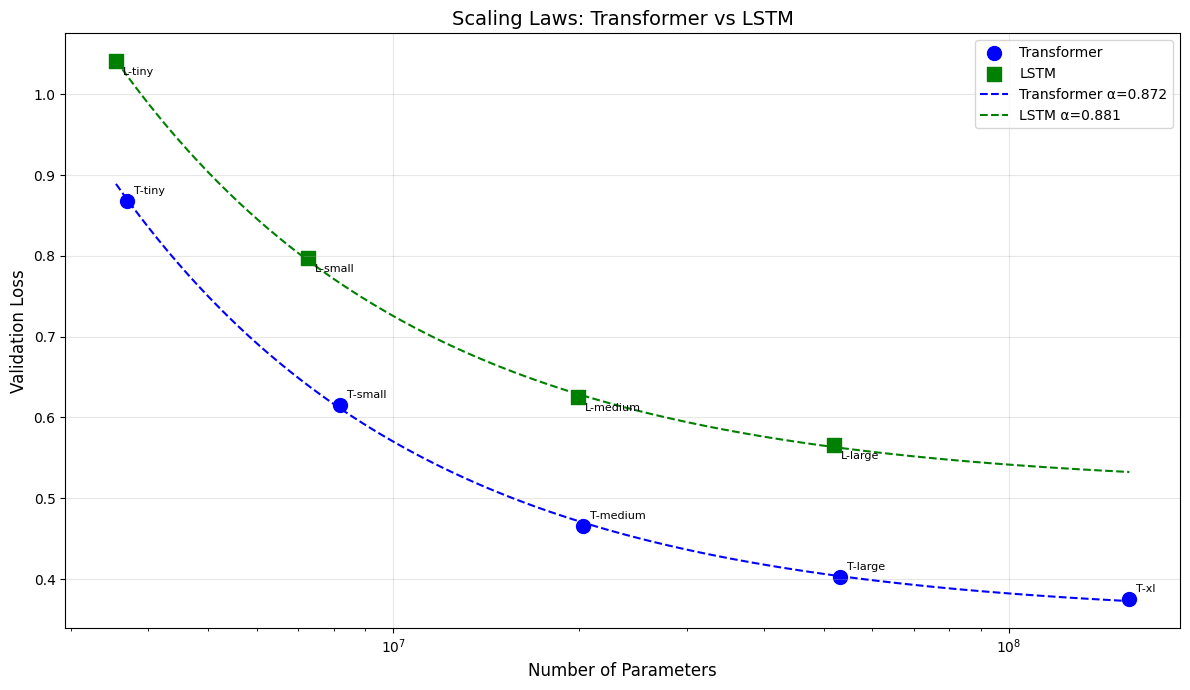

In [ ]:
plt.figure(figsize=(12, 7))

plt.scatter(transformer_params, transformer_val_losses, s=100, c='blue', marker='o', label='Transformer')
plt.scatter(lstm_params, lstm_val_losses, s=100, c='green', marker='s', label='LSTM')

for r in transformer_results:
    plt.annotate(f"T-{r['model_name']}", (r['n_params'], r['final_val_loss']),
                 textcoords="offset points", xytext=(5,5), fontsize=8)

for r in lstm_results:
    plt.annotate(f"L-{r['model_name']}", (r['n_params'], r['final_val_loss']),
                 textcoords="offset points", xytext=(5,-10), fontsize=8)

all_params = transformer_params + lstm_params
x_fit = np.logspace(np.log10(min(all_params)), np.log10(max(all_params)), 100)

if a_trans is not None:
    y_fit_trans = power_law(x_fit, a_trans, alpha_trans, c_trans)
    plt.plot(x_fit, y_fit_trans, 'b--', label=f'Transformer α={alpha_trans:.3f}')

if a_lstm is not None:
    y_fit_lstm = power_law(x_fit, a_lstm, alpha_lstm, c_lstm)
    plt.plot(x_fit, y_fit_lstm, 'g--', label=f'LSTM α={alpha_lstm:.3f}')

plt.xscale('log')
plt.xlabel('Number of Parameters', fontsize=12)
plt.ylabel('Validation Loss', fontsize=12)
plt.title('Scaling Laws: Transformer vs LSTM', fontsize=14)
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.savefig(output_dir / 'comparison_scaling_plot.png', dpi=150)
plt.show()

## Computational Efficiency Comparison

In [ ]:
print("\n" + "="*90)
print("COMPUTATIONAL EFFICIENCY COMPARISON")
print("="*90)
print(f"{'Model':<15} {'Architecture':<12} {'Params':>12} {'Val Loss':>10} {'Time (min)':>12} {'GPU (GB)':>10}")
print("-"*90)

for r in transformer_results:
    print(f"{r['model_name']:<15} {'Transformer':<12} {r['n_params']:>12,} {r['final_val_loss']:>10.4f} {r['train_time_seconds']/60:>12.1f} {r['gpu_memory_gb']:>10.2f}")

print("-"*90)

for r in lstm_results:
    print(f"{r['model_name']:<15} {'LSTM':<12} {r['n_params']:>12,} {r['final_val_loss']:>10.4f} {r['train_time_seconds']/60:>12.1f} {r['gpu_memory_gb']:>10.2f}")

print("="*90)


COMPUTATIONAL EFFICIENCY COMPARISON
Model           Architecture       Params   Val Loss   Time (min)   GPU (GB)
------------------------------------------------------------------------------------------
tiny            Transformer     3,701,120     0.8684          5.7       2.08
small           Transformer     8,192,000     0.6150          8.7       2.36
medium          Transformer    20,322,816     0.4662         16.0       3.25
large           Transformer    53,228,544     0.4021         32.5       4.24
xl              Transformer   156,788,736     0.3751         88.5       7.50
------------------------------------------------------------------------------------------
tiny            LSTM            3,545,176     1.0413         10.3       1.86
small           LSTM            7,260,760     0.7972         12.8       1.92
medium          LSTM           19,915,864     0.6251         26.5       2.18
large           LSTM           51,870,424     0.5656         57.0       2.80


## Scaling Exponent Comparison

In [ ]:
print("\n" + "="*50)
print("SCALING EXPONENT COMPARISON")
print("="*50)
if alpha_trans is not None:
    print(f"Transformer α = {alpha_trans:.4f}")
if alpha_lstm is not None:
    print(f"LSTM α = {alpha_lstm:.4f}")
print("="*50)
print("\nHigher α = steeper scaling = better improvement with size")
if alpha_trans is not None and alpha_lstm is not None:
    if alpha_trans > alpha_lstm:
        print("Transformer scales better with model size.")
    else:
        print("LSTM scales better with model size.")
print("="*50)


SCALING EXPONENT COMPARISON
Transformer α = 0.8717
LSTM α = 0.8813

Higher α = steeper scaling = better improvement with size
LSTM scales better with model size.


## Time and Memory per Parameter

In [ ]:
print("\n" + "="*70)
print("TIME AND MEMORY PER MILLION PARAMETERS")
print("="*70)
print(f"{'Model':<15} {'Architecture':<12} {'Time/M params':>15} {'Memory/M params':>15}")
print("-"*70)

for r in transformer_results:
    time_per_m = (r['train_time_seconds']/60) / (r['n_params']/1e6)
    mem_per_m = r['gpu_memory_gb'] / (r['n_params']/1e6)
    print(f"{r['model_name']:<15} {'Transformer':<12} {time_per_m:>12.2f} min {mem_per_m:>12.4f} GB")

print("-"*70)

for r in lstm_results:
    time_per_m = (r['train_time_seconds']/60) / (r['n_params']/1e6)
    mem_per_m = r['gpu_memory_gb'] / (r['n_params']/1e6)
    print(f"{r['model_name']:<15} {'LSTM':<12} {time_per_m:>12.2f} min {mem_per_m:>12.4f} GB")

print("="*70)


TIME AND MEMORY PER MILLION PARAMETERS
Model           Architecture   Time/M params Memory/M params
----------------------------------------------------------------------
tiny            Transformer          1.53 min       0.5612 GB
small           Transformer          1.06 min       0.2880 GB
medium          Transformer          0.79 min       0.1600 GB
large           Transformer          0.61 min       0.0797 GB
xl              Transformer          0.56 min       0.0478 GB
----------------------------------------------------------------------
tiny            LSTM                 2.92 min       0.5233 GB
small           LSTM                 1.76 min       0.2650 GB
medium          LSTM                 1.33 min       0.1097 GB
large           LSTM                 1.10 min       0.0541 GB
